<a href="https://colab.research.google.com/github/Lyynn777/CUDA-Bitonic-sort/blob/main/Bitonic-sort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numba matplotlib ipywidgets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00


In [ ]:
from numba import cuda

if cuda.is_available():
    print("CUDA is available!")
    print("GPU Device:", cuda.get_current_device().name)
else:
    print("CUDA is NOT available.")


CUDA is available!
GPU Device: b'Tesla T4'


Original array: [44 47 64 67 67  9 83 21 36 87 70 88 88 12 58 65 39 87 46 88 81 37 25 77
 72  9 20 80 69 79 47 64]
Sorted array (CPU): [ 9  9 12 20 21 25 36 37 39 44 46 47 47 58 64 64 65 67 67 69 70 72 77 79
 80 81 83 87 87 88 88 88]
CPU sorting took 0.003332 seconds


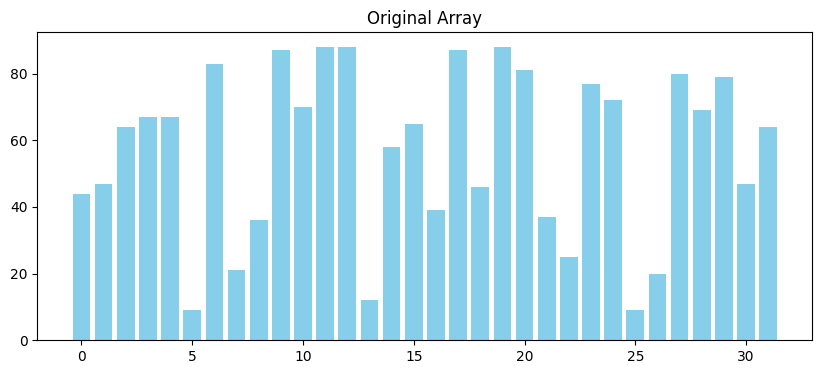

In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

# Create a random array of size 32 (must be a power of 2 for Bitonic Sort)
array_size = 32
np.random.seed(0)  # For reproducibility
arr = np.random.randint(0, 100, size=array_size)

# CPU sorting using numpy for reference
start_time = time.time()
sorted_arr = np.sort(arr)
cpu_time = time.time() - start_time

print("Original array:", arr)
print("Sorted array (CPU):", sorted_arr)
print(f"CPU sorting took {cpu_time:.6f} seconds")

# Plot the original array
plt.figure(figsize=(10,4))
plt.bar(range(array_size), arr, color='skyblue')
plt.title("Original Array")
plt.show()


In [ ]:
from numba import cuda

@cuda.jit
def bitonic_sort(arr, stage, seq):
    idx = cuda.grid(1)  # 1D thread index

    if idx >= arr.size:
        return

    pair_distance = 1 << (stage - 1)
    block_size = 1 << stage

    # Find the start of the block this thread is in
    block_start = (idx // pair_distance) * pair_distance * 2

    # Index of the element to compare with
    i = idx
    j = i ^ pair_distance

    if j > i:
        ascending = ((i & block_size) == 0)

        if (arr[i] > arr[j]) == ascending:
            # Swap elements
            temp = arr[i]
            arr[i] = arr[j]
            arr[j] = temp


In [ ]:
def gpu_bitonic_sort(arr):
    # Copy array to GPU
    d_arr = cuda.to_device(arr)

    n = arr.size
    threads_per_block = 32
    blocks = (n + threads_per_block - 1) // threads_per_block

    # Run stages from 1 to log2(n)
    stages = int(np.log2(n))
    for stage in range(1, stages + 1):
        for seq in range(stage, 0, -1):
            bitonic_sort[blocks, threads_per_block](d_arr, stage, seq)

    # Copy result back to CPU
    sorted_arr = d_arr.copy_to_host()
    return sorted_arr


In [ ]:
!apt-get install -y python3-dev libcuda1-460
!pip install pycuda matplotlib numpy ipywidgets


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package libcuda1-460
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 29.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 10.7 MB/s eta 0:00:00
  Created wheel for pycuda: filename=pycuda-2025.1.2-cp312-cp312-linux_x86_64.whl size=659050 sha256=dba826d61a78384c21515887c6d88a67aafe3d695c8658845d9fc450aff100b6
  Stored in directory: /root/.cache/pip/wheels/d5/36/f3/ac5f09d768cad3fa15d5a3449bdfe65c3de58e69d036c73228
Successfully built pycuda


In [ ]:
import pycuda.driver as cuda
import pycuda.autoinit

print("CUDA device is ready:", cuda.Device(0).name())


CUDA device is ready: Tesla T4


In [ ]:
import pycuda.autoinit
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import numpy as np
import matplotlib.pyplot as plt
import time

# CUDA kernel for Bitonic Sort
bitonic_kernel_code = """
__global__ void bitonic_sort(int *arr, int j, int k, int n) {
    unsigned int i = threadIdx.x + blockDim.x * blockIdx.x;
    unsigned int ixj = i ^ j;

    if (ixj > i) {
        if ((i & k) == 0) {
            if (arr[i] > arr[ixj]) {
                int temp = arr[i];
                arr[i] = arr[ixj];
                arr[ixj] = temp;
            }
        } else {
            if (arr[i] < arr[ixj]) {
                int temp = arr[i];
                arr[i] = arr[ixj];
                arr[ixj] = temp;
            }
        }
    }
}
"""

# Compile the CUDA kernel
mod = SourceModule(bitonic_kernel_code)
bitonic_sort = mod.get_function("bitonic_sort")


Original array: [44 47 64 67 67  9 83 21 36 87 70 88 88 12 58 65 39 87 46 88 81 37 25 77
 72  9 20 80 69 79 47 64]
Sorted array (CPU): [ 9  9 12 20 21 25 36 37 39 44 46 47 47 58 64 64 65 67 67 69 70 72 77 79
 80 81 83 87 87 88 88 88]
Sorted array (GPU): [ 9  9 12 20 21 25 36 37 39 44 46 47 47 58 64 64 65 67 67 69 70 72 77 79
 80 81 83 87 87 88 88 88]
CPU sorting took 0.000732 seconds
GPU sorting took 0.001878 seconds
Sorting correct? True


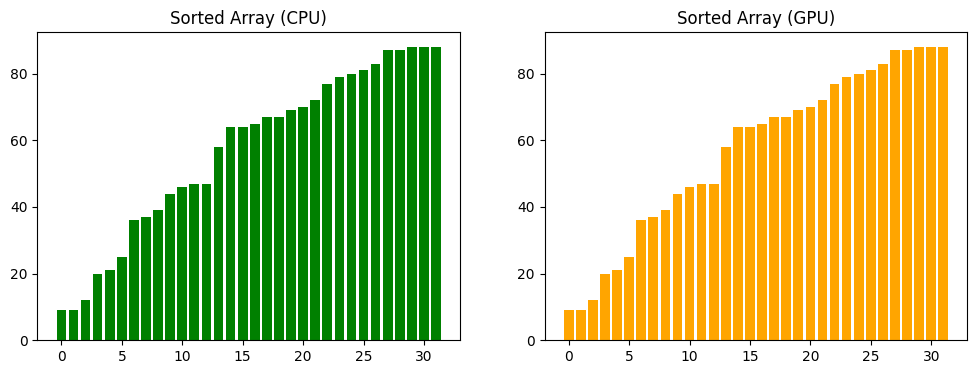

In [ ]:
# Create a random array of size 32 (must be power of 2)
array_size = 32
np.random.seed(0)
arr = np.random.randint(0, 100, size=array_size).astype(np.int32)

# Allocate memory on the GPU and transfer the array
arr_gpu = cuda.mem_alloc(arr.nbytes)
cuda.memcpy_htod(arr_gpu, arr)

# Perform Bitonic Sort
n = array_size
threads_per_block = 32
blocks = (n + threads_per_block - 1) // threads_per_block

start_time = time.time()
# Outer loop for k (size of subsequences)
k = 2
while k <= n:
    j = k >> 1
    while j > 0:
        bitonic_sort(arr_gpu,
                     np.int32(j), np.int32(k), np.int32(n),
                     block=(threads_per_block, 1, 1), grid=(blocks, 1))
        j = j >> 1
    k = k << 1
gpu_time = time.time() - start_time

# Copy the sorted array back to CPU
sorted_arr_gpu = np.empty_like(arr)
cuda.memcpy_dtoh(sorted_arr_gpu, arr_gpu)

# Sort using CPU for comparison
start_time = time.time()
sorted_arr_cpu = np.sort(arr)
cpu_time = time.time() - start_time

# Check correctness
is_correct = np.array_equal(sorted_arr_cpu, sorted_arr_gpu)

print("Original array:", arr)
print("Sorted array (CPU):", sorted_arr_cpu)
print("Sorted array (GPU):", sorted_arr_gpu)
print(f"CPU sorting took {cpu_time:.6f} seconds")
print(f"GPU sorting took {gpu_time:.6f} seconds")
print("Sorting correct?", is_correct)

# Plotting the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].bar(range(n), sorted_arr_cpu, color='green')
axs[0].set_title("Sorted Array (CPU)")
axs[1].bar(range(n), sorted_arr_gpu, color='orange')
axs[1].set_title("Sorted Array (GPU)")
plt.show()


Array size: 512
CPU time: 0.000048 sec | GPU time: 0.000857 sec | Correct? True

Array size: 1024
CPU time: 0.000027 sec | GPU time: 0.000703 sec | Correct? True

Array size: 2048
CPU time: 0.000026 sec | GPU time: 0.001084 sec | Correct? True



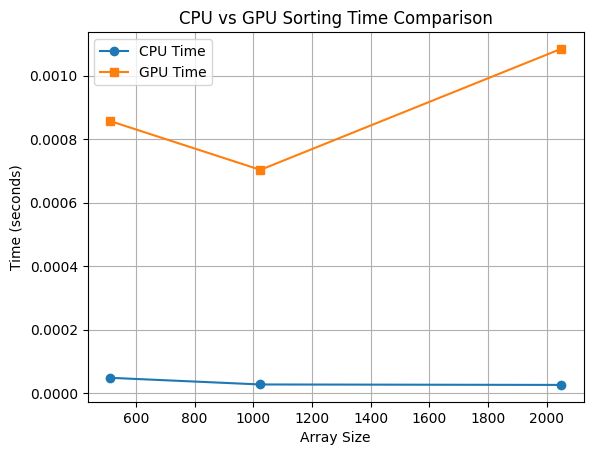

In [ ]:
array_sizes = [512, 1024, 2048]
cpu_times = []
gpu_times = []

for n in array_sizes:
    print(f"Array size: {n}")

    # Create random array
    np.random.seed(0)
    arr = np.random.randint(0, 10000, size=n).astype(np.int32)

    # CPU sort
    start = time.time()
    sorted_cpu = np.sort(arr)
    cpu_time = time.time() - start
    cpu_times.append(cpu_time)

    # GPU sort
    arr_gpu = cuda.mem_alloc(arr.nbytes)
    cuda.memcpy_htod(arr_gpu, arr)
    threads_per_block = 512
    blocks = (n + threads_per_block - 1) // threads_per_block

    start = time.time()
    k = 2
    while k <= n:
        j = k >> 1
        while j > 0:
            bitonic_sort(arr_gpu,
                         np.int32(j), np.int32(k), np.int32(n),
                         block=(threads_per_block, 1, 1), grid=(blocks, 1))
            j = j >> 1
        k = k << 1
    gpu_time = time.time() - start
    gpu_times.append(gpu_time)

    sorted_gpu = np.empty_like(arr)
    cuda.memcpy_dtoh(sorted_gpu, arr_gpu)

    is_correct = np.array_equal(sorted_cpu, sorted_gpu)
    print(f"CPU time: {cpu_time:.6f} sec | GPU time: {gpu_time:.6f} sec | Correct? {is_correct}\n")

# Plotting the results
plt.plot(array_sizes, cpu_times, marker='o', label='CPU Time')
plt.plot(array_sizes, gpu_times, marker='s', label='GPU Time')
plt.xlabel("Array Size")
plt.ylabel("Time (seconds)")
plt.title("CPU vs GPU Sorting Time Comparison")
plt.legend()
plt.grid(True)
plt.show()


Array size: 512
CPU time: 0.000143 sec | GPU time: 0.001416 sec | Correct? True

Array size: 1024
CPU time: 0.000025 sec | GPU time: 0.000571 sec | Correct? True

Array size: 2048
CPU time: 0.000273 sec | GPU time: 0.001343 sec | Correct? True

Array size: 4096
CPU time: 0.000029 sec | GPU time: 0.000692 sec | Correct? True

Array size: 8192
CPU time: 0.000049 sec | GPU time: 0.000782 sec | Correct? True

Array size: 16384
CPU time: 0.000092 sec | GPU time: 0.000933 sec | Correct? True



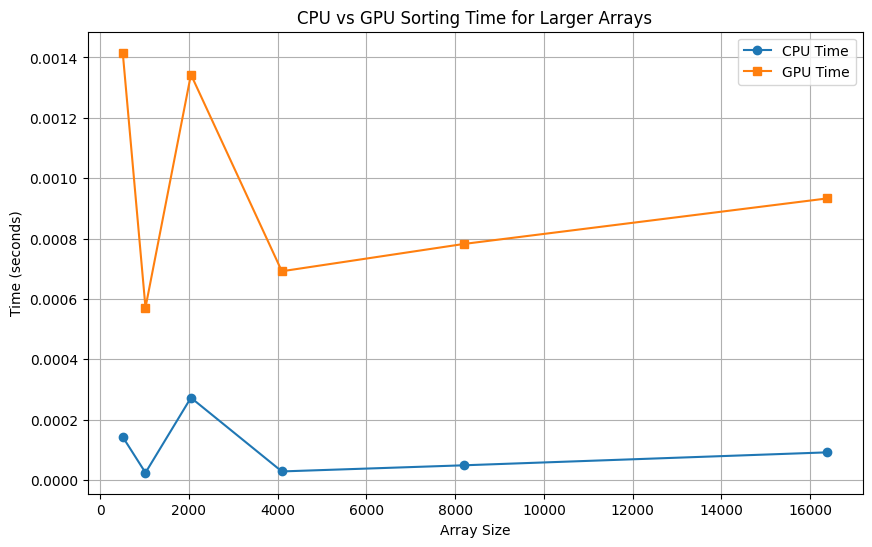

In [ ]:
# Larger array sizes for experimentation
array_sizes = [512, 1024, 2048, 4096, 8192, 16384]
cpu_times = []
gpu_times = []

for n in array_sizes:
    print(f"Array size: {n}")

    # Create random array
    np.random.seed(0)
    arr = np.random.randint(0, 10000, size=n).astype(np.int32)

    # CPU sort
    start = time.time()
    sorted_cpu = np.sort(arr)
    cpu_time = time.time() - start
    cpu_times.append(cpu_time)

    # GPU sort
    arr_gpu = cuda.mem_alloc(arr.nbytes)
    cuda.memcpy_htod(arr_gpu, arr)
    threads_per_block = 512
    blocks = (n + threads_per_block - 1) // threads_per_block

    start = time.time()
    k = 2
    while k <= n:
        j = k >> 1
        while j > 0:
            bitonic_sort(arr_gpu,
                         np.int32(j), np.int32(k), np.int32(n),
                         block=(threads_per_block, 1, 1), grid=(blocks, 1))
            j = j >> 1
        k = k << 1
    gpu_time = time.time() - start
    gpu_times.append(gpu_time)

    sorted_gpu = np.empty_like(arr)
    cuda.memcpy_dtoh(sorted_gpu, arr_gpu)

    is_correct = np.array_equal(sorted_cpu, sorted_gpu)
    print(f"CPU time: {cpu_time:.6f} sec | GPU time: {gpu_time:.6f} sec | Correct? {is_correct}\n")

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(array_sizes, cpu_times, marker='o', label='CPU Time')
plt.plot(array_sizes, gpu_times, marker='s', label='GPU Time')
plt.xlabel("Array Size")
plt.ylabel("Time (seconds)")
plt.title("CPU vs GPU Sorting Time for Larger Arrays")
plt.legend()
plt.grid(True)
plt.show()
